# Tomato Disease Detection

## 1. Filter image duplication
Check the image duplication in the same folder than the duplicate will be deleted.

In [1]:
import os
from PIL import Image
import imagehash
from tqdm import tqdm
import shutil

# === CONFIGURATION ===
DATASET_DIR = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/full"  # directory data source
HASH_FUNC = imagehash.phash
THRESHOLD = 5                          # 0 = exact match, 1–5 = similar images allowed
DELETE_DUPLICATES = True
BACKUP_DUPLICATES = False              # move duplicates to backup instead of deleting

# === IMPLEMENTATION ===
def remove_duplicates_in_folder(folder_path):
    hash_to_file = {}
    duplicates = []

    image_files = [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    for filepath in image_files:
        try:
            img = Image.open(filepath)
            img_hash = HASH_FUNC(img)
        except Exception as e:
            print(f"Skipping {filepath}: {e}")
            continue

        found = False
        for existing_hash in hash_to_file:
            if abs(img_hash - existing_hash) <= THRESHOLD:
                duplicates.append((filepath, hash_to_file[existing_hash]))
                found = True
                break

        if not found:
            hash_to_file[img_hash] = filepath

    if DELETE_DUPLICATES and duplicates:
        if BACKUP_DUPLICATES:
            backup_dir = os.path.join(folder_path, "_duplicates_backup")
            os.makedirs(backup_dir, exist_ok=True)

        for dup, keep in duplicates:
            try:
                if BACKUP_DUPLICATES:
                    shutil.move(dup, os.path.join(backup_dir, os.path.basename(dup)))
                else:
                    os.remove(dup)
            except Exception as e:
                print(f"Error deleting {dup}: {e}")

    return len(duplicates)


def find_and_remove_duplicates_within_folders(root_folder):
    class_folders = [
        os.path.join(root_folder, d)
        for d in os.listdir(root_folder)
        if os.path.isdir(os.path.join(root_folder, d))
    ]

    total_deleted = 0
    for class_folder in tqdm(class_folders, desc="Processing folders"):
        num_deleted = remove_duplicates_in_folder(class_folder)
        print(f"{os.path.basename(class_folder)} — removed {num_deleted} duplicates.")
        total_deleted += num_deleted

    print(f"\nFinished. Total duplicates removed: {total_deleted}")


# === RUN ===
if __name__ == "__main__":
    find_and_remove_duplicates_within_folders(DATASET_DIR)

Processing folders:   9%|▉         | 1/11 [00:38<06:28, 38.89s/it]

Bacterial_spot — removed 0 duplicates.


Processing folders:  18%|█▊        | 2/11 [01:13<05:29, 36.62s/it]

Early_blight — removed 0 duplicates.


Processing folders:  27%|██▋       | 3/11 [02:04<05:45, 43.21s/it]

healthy — removed 0 duplicates.


Processing folders:  36%|███▋      | 4/11 [02:47<05:01, 43.09s/it]

Late_blight — removed 0 duplicates.


Processing folders:  45%|████▌     | 5/11 [03:26<04:08, 41.44s/it]

Leaf_Mold — removed 0 duplicates.


Processing folders:  55%|█████▍    | 6/11 [03:34<02:30, 30.12s/it]

powdery_mildew — removed 0 duplicates.


Processing folders:  64%|██████▎   | 7/11 [04:15<02:14, 33.52s/it]

Septoria_leaf_spot — removed 0 duplicates.


Processing folders:  73%|███████▎  | 8/11 [04:38<01:30, 30.31s/it]

Spider_mites Two-spotted_spider_mite — removed 0 duplicates.


Processing folders:  82%|████████▏ | 9/11 [05:04<00:57, 28.84s/it]

Target_Spot — removed 0 duplicates.


Processing folders:  91%|█████████ | 10/11 [05:31<00:28, 28.53s/it]

Tomato_mosaic_virus — removed 0 duplicates.


Processing folders: 100%|██████████| 11/11 [06:03<00:00, 33.08s/it]

Tomato_Yellow_Leaf_Curl_Virus — removed 0 duplicates.

Finished. Total duplicates removed: 0


## 2. Infected and health leaves category distribution

Scanning folders: 12it [00:00, 100.47it/s]



 Category distribution:

                            Category  Image Count
                         Late_blight         3291
                             healthy         3151
                  Septoria_leaf_spot         3107
                      Bacterial_spot         2970
                           Leaf_Mold         2939
                        Early_blight         2715
       Tomato_Yellow_Leaf_Curl_Virus         2526
                         Target_Spot         2248
                 Tomato_mosaic_virus         2246
Spider_mites Two-spotted_spider_mite         2177
                      powdery_mildew          957


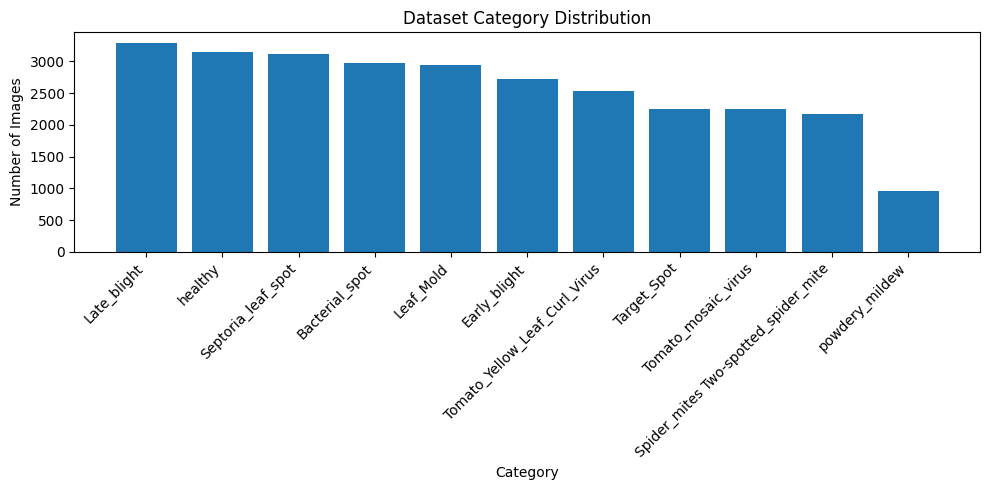

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# === CONFIGURATION ===
#DATASET_DIR = "path_to_your_dataset"  # e.g. "./dataset"
VALID_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp", ".gif")

# === IMPLEMENTATION ===
def get_category_distribution(root_folder):
    category_counts = {}

    # Loop through all subfolders
    for root, dirs, files in tqdm(os.walk(root_folder), desc="Scanning folders"):
        # Only count files if this folder directly contains images
        image_files = [f for f in files if f.lower().endswith(VALID_EXTENSIONS)]
        if image_files:
            # Folder name (class label)
            label = os.path.basename(root)
            category_counts[label] = category_counts.get(label, 0) + len(image_files)

    # Convert to DataFrame for better formatting
    df = pd.DataFrame(list(category_counts.items()), columns=["Category", "Image Count"])
    df = df.sort_values("Image Count", ascending=False).reset_index(drop=True)

    return df

def plot_distribution(df, title="Dataset Category Distribution"):
    plt.figure(figsize=(10, 5))
    plt.bar(df["Category"], df["Image Count"])
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.xlabel("Category")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()


# === RUN ===
if __name__ == "__main__":
    df = get_category_distribution(DATASET_DIR)
    print("\n Category distribution:\n")
    print(df.to_string(index=False))

    plot_distribution(df)

Result: there is imbalance dataset, so that we will use balancing technique so that the minority target will not be discriminated.

## 3. Call all libraries required

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow')

## 4. Data preparation

In [4]:
DATASET_DIR = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/full"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # MobileNetV2 expects [-1, 1]
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

Found 22665 images belonging to 11 classes.
Found 5662 images belonging to 11 classes.


## 5. Compute class weight for imbalance correction

In [5]:
labels = train_gen.classes
classes = np.unique(labels)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
class_weights = dict(enumerate(cw))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.8671946740128559), 1: np.float64(0.9486438975389252), 2: np.float64(0.7825501501916238), 3: np.float64(0.876043599257885), 4: np.float64(0.8288232282600746), 5: np.float64(1.182809727585847), 6: np.float64(1.145333265955834), 7: np.float64(1.0195222886959652), 8: np.float64(1.146607983001973), 9: np.float64(0.8173163607515055), 10: np.float64(2.689888440541182)}


## 6. Model setup for MobileNetV2

In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # freeze base initially

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 7. Callback

In [7]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
ckpt = ModelCheckpoint('best_mobilenetv2_tomato.keras',
                       monitor='val_accuracy',
                       save_best_only=True,
                       verbose=1)

## 8. Train base model (frozen)

In [8]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[es, ckpt]
)

C:\Users\ekadw\anaconda3\envs\Tensorflow31018\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.3006 - loss: 2.0460   
Epoch 1: val_accuracy improved from -inf to 0.71989, saving model to best_mobilenetv2_tomato.keras
709/709 ━━━━━━━━━━━━━━━━━━━━ 790s 1s/step - accuracy: 0.3008 - loss: 2.0454 - val_accuracy: 0.7199 - val_loss: 0.9266
Epoch 2/30
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.6040 - loss: 1.1407  
Epoch 2: val_accuracy improved from 0.71989 to 0.76492, saving model to best_mobilenetv2_tomato.keras
709/709 ━━━━━━━━━━━━━━━━━━━━ 578s 816ms/step - accuracy: 0.6040 - loss: 1.1406 - val_accuracy: 0.7649 - val_loss: 0.7375
Epoch 3/30
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.6625 - loss: 0.9510  
Epoch 3: val_accuracy improved from 0.76492 to 0.78453, saving model to best_mobilenetv2_tomato.keras
709/709 ━━━━━━━━━━━━━━━━━━━━ 578s 815ms/step - accuracy: 0.6626 - loss: 0.9510 - val_accuracy: 0.7845 - val_loss: 0.6471
Epoch 4/30
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 

## 9. Fine tunning (unfreeze top layers)

In [9]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weights,
    callbacks=[es, ckpt]
)

Epoch 1/15
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6596 - loss: 0.9803      
Epoch 1: val_accuracy did not improve from 0.88926
709/709 ━━━━━━━━━━━━━━━━━━━━ 904s 1s/step - accuracy: 0.6597 - loss: 0.9800 - val_accuracy: 0.8518 - val_loss: 0.4506
Epoch 2/15
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7940 - loss: 0.5657      
Epoch 2: val_accuracy did not improve from 0.88926
709/709 ━━━━━━━━━━━━━━━━━━━━ 876s 1s/step - accuracy: 0.7940 - loss: 0.5657 - val_accuracy: 0.8735 - val_loss: 0.3664
Epoch 3/15
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8281 - loss: 0.4698   
Epoch 3: val_accuracy did not improve from 0.88926
709/709 ━━━━━━━━━━━━━━━━━━━━ 873s 1s/step - accuracy: 0.8281 - loss: 0.4698 - val_accuracy: 0.8864 - val_loss: 0.3335
Epoch 4/15
709/709 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8503 - loss: 0.4194      
Epoch 4: val_accuracy improved from 0.88926 to 0.89721, saving model to best_mobilenetv2_tomato.keras
709/709 ━━━━━━━━━━━━━━━━━━━━ 8

## 10. Evaluation

In [10]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"\n Validation Accuracy after fine-tuning: {val_acc:.4f}")

177/177 ━━━━━━━━━━━━━━━━━━━━ 157s 888ms/step - accuracy: 0.9274 - loss: 0.2078

 Validation Accuracy after fine-tuning: 0.9318


## 11. Plot training vs validation accuracy

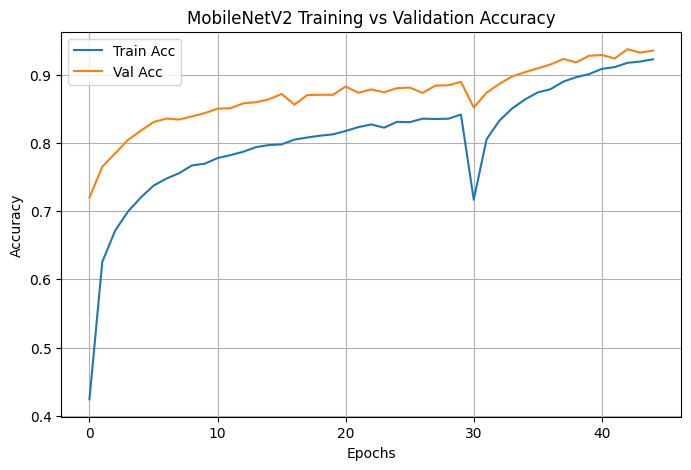

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'] + fine_history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + fine_history.history['val_accuracy'], label='Val Acc')
plt.title("MobileNetV2 Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## 12. Test model prediction

Model loaded successfully.
Class names: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

 Prediction Result:
Class: powdery_mildew
Confidence: 89.39%


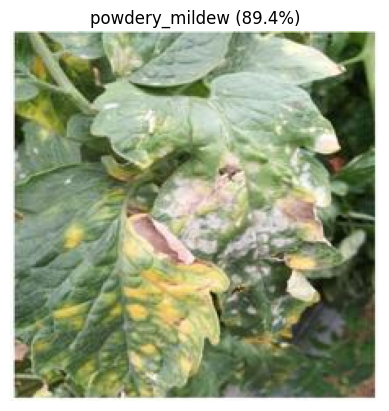

In [12]:
import tensorflow as tf
import numpy as np
import cv2
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# ======================================================
# STEP 1: LOAD MODEL & CLASS NAMES
# ======================================================
MODEL_PATH = "best_mobilenetv2_tomato.keras"   # or  mobilenetv2_tomato_final.keras
DATASET_DIR = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/full"
IMG_SIZE = (224, 224)

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully.")

# Recreate class names (from training directory)
class_names = sorted(os.listdir(DATASET_DIR))
print("Class names:", class_names)

# ======================================================
# STEP 2: LOAD AND PREPROCESS IMAGE
# ======================================================
def prepare_image(image_path):
    # Read image
    image = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)        # MobileNetV2 preprocessing
    return img_array

# Example image
image_path = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/Tomato20000/full/powdery_mildew/pm5.jpg"  # 🔹 Change this path
img = prepare_image(image_path)

# ======================================================
# STEP 3: PREDICT
# ======================================================
preds = model.predict(img)
pred_class_idx = np.argmax(preds, axis=1)[0]
confidence = preds[0][pred_class_idx]

predicted_class = class_names[pred_class_idx]

print(f"\n Prediction Result:")
print(f"Class: {predicted_class}")
print(f"Confidence: {confidence:.2%}")

# ======================================================
# (Optional) Display the image with prediction
# ======================================================
import matplotlib.pyplot as plt

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"{predicted_class} ({confidence:.1%})")
plt.axis("off")
plt.show()

## 13. Load model

In [13]:
#from tensorflow.keras.models import load_model
#model = load_model("best_mobilenetv2_tomato.keras")

## 14. Create class indices for app.py

In [17]:
import json

with open("class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f)